##### - Estudo feito no kaggle pela DA - Alena Vorushilova, com a base de dados industrial retida do kaggle.
Bruno Souza - DS

# Produção Industrial  com série temporal e previsões.

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose # para descomposição da série temporal
from statsmodels.tsa.stattools import adfuller # teste de estacionariedade
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # para plotar os gráficos ACF e PACF
from pandas.plotting import autocorrelation_plot # para plotar o gráfico de autocorrelação
from statsmodels.tsa.arima_model import ARIMA # para o modelo ARIMA
from statsmodels.tsa.arima_model import ARIMAResults # para o resultado do modelo ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX # para o modelo SARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAXResults # para o resultado do modelo SARIMA
from pandas.tseries.offsets import DateOffset # para fazer previsões

import matplotlib.pyplot as plt
%matplotlib inline

# Suprimir avisos
import warnings
warnings.filterwarnings('ignore')

## Carregando os dados.

In [ ]:
df = pd.read_csv("INDPRO.csv")
df.head()

,DATE,INDPRO
0,1919-01-01,5.0124
1,1919-02-01,4.7908
2,1919-03-01,4.6524
3,1919-04-01,4.7355
4,1919-05-01,4.7632


In [ ]:
df.columns = ['Date', 'IPI'] # Renomeando as colunas
df.head()

,Date,IPI
0,1919-01-01,5.0124
1,1919-02-01,4.7908
2,1919-03-01,4.6524
3,1919-04-01,4.7355
4,1919-05-01,4.7632


In [ ]:
# Verificando o tipo de dados e se há valores nulos
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1212 entries, 0 to 1211
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1212 non-null   object 
 1   IPI     1212 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.1+ KB


Date    0
IPI     0
dtype: int64

In [ ]:
df['Date'] = pd.to_datetime(df['Date']) # Convertendo a coluna Date para datetime

In [ ]:
# Coloca a coluna Date como índice e salvando
df.set_index ('Date', inplace = True)
df.index

DatetimeIndex(['1919-01-01', '1919-02-01', '1919-03-01', '1919-04-01',
               '1919-05-01', '1919-06-01', '1919-07-01', '1919-08-01',
               '1919-09-01', '1919-10-01',
               ...
               '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01',
               '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01',
               '2019-11-01', '2019-12-01'],
              dtype='datetime64[ns]', name='Date', length=1212, freq=None)

In [ ]:
#Criando uma variável e checando os dados
df_new = df['1998-01-01':]
df_new.tail()

,IPI
Date,
2019-08-01,109.9634
2019-09-01,109.4437
2019-10-01,108.8532
2019-11-01,109.7573
2019-12-01,109.4330


In [ ]:
df_new.describe().transpose() # Verificando a estatística descritiva

,count,mean,std,min,25%,50%,75%,max
IPI,264.0,98.764683,6.123998,86.6474,93.704625,99.53835,103.611375,110.5516


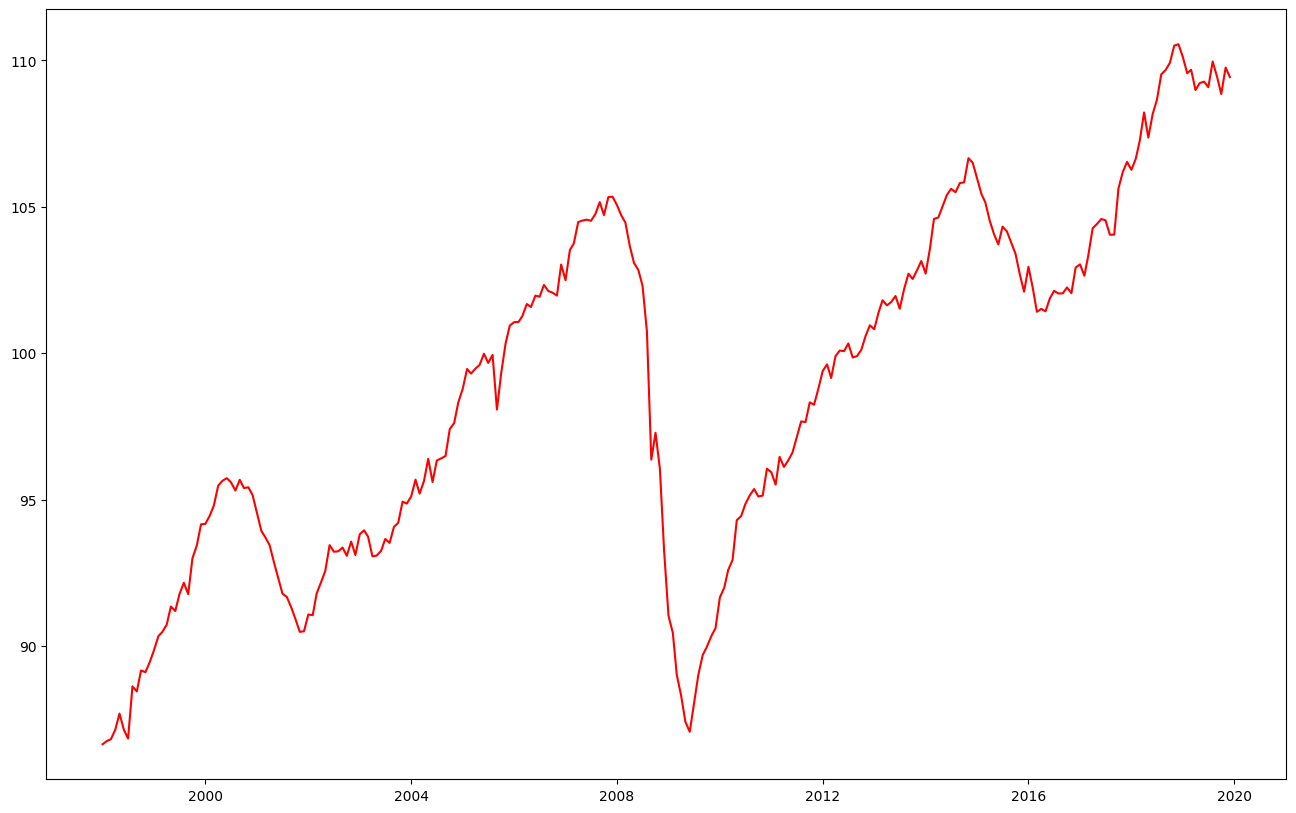

In [ ]:
f, ax = plt.subplots(figsize = (16,10)) # Plotando o gráfico
ax.plot(df_new, c = 'r');

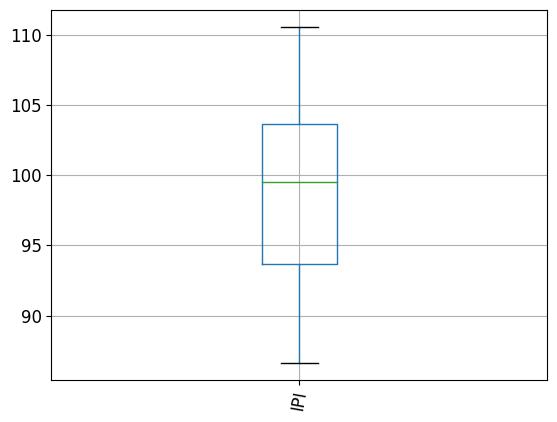

In [ ]:
# rot = gira os rótulos na parte inferior
# fontsize = tamanho das labels
# grid False or True

df_new.boxplot('IPI', rot = 80, fontsize = '12',grid = True); # Plotando o boxplot

## Estacionaridade

A média, variância e covariância do i-ésimo e do (i+m)-ésimo termo da série não devem depender do tempo. A maioria dos métodos estatísticos assume ou exige que a série seja estacionária.

In [ ]:
time_series = df_new['IPI'] # Criando uma variável para a série temporal
type(time_series) # Verificando o tipo de dados

pandas.core.series.Series

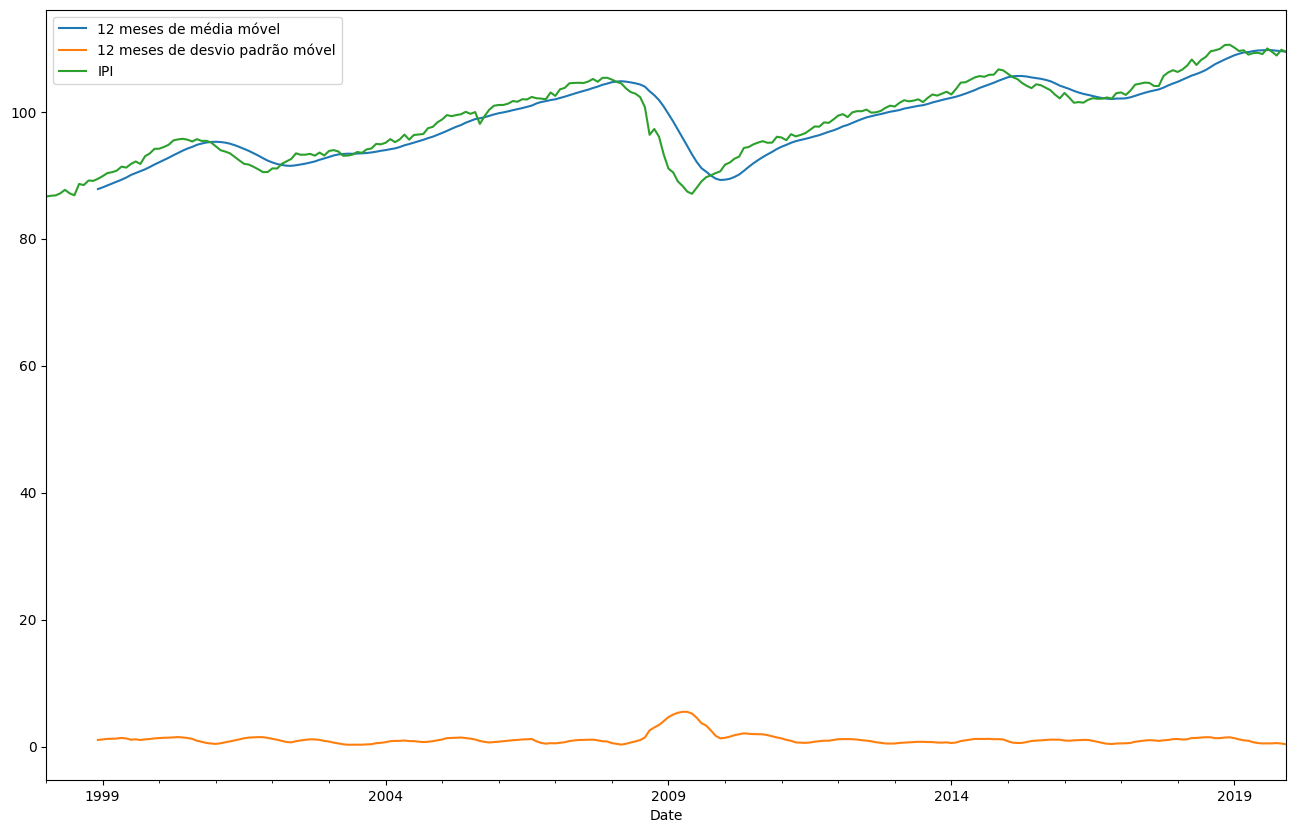

In [ ]:
time_series.rolling(12).mean().plot(label = '12 meses de média móvel', figsize = (16,10)) # Plotando a média móvel, utilizando 12 meses
time_series.rolling(12).std().plot(label = '12 meses de desvio padrão móvel')
time_series.plot()
plt.legend();

Como a média móvel e o desvio padrão móvel aumentam ao longo do tempo, as séries temporais são não estacionárias.

## Teste Dickey-Fuller
### Hipótese nula de que as séries são não estacionárias.
### Hipótese alternativa: as séries são estacionárias.
### Os dados são considerados estacionários se o valor p for menor que 0,05 e a estatística ADF estiver próxima dos valores críticos.

In [ ]:
result = adfuller(df_new['IPI']) # Teste de Dickey-Fuller, para verificar se a série é estacionária, ou seja, se não há tendência. Usando a função adfuller do statsmodels.

In [ ]:
# Criando uma função para imprimir o resultado do teste de Dickey-Fuller
def adf_check(time_series):
    
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test') 
    labels = ['ADF Test Statistic', 'p-value', '# of lags', 'Num of Obs used']
    
    print('Critical values:')
    for key,value in result[4].items():
        print('\t{}: {}'.format(key, value) )
    
    for value, label in zip(result,labels):
        print(label+ ' : '+str(value))
    
    if ((result[1] <= 0.05 and  result[0] <= result[4]['1%']) or
    (result[1] <= 0.05 and  result[0] <= result[4]['5%']) or
        (result[1] <= 0.05 and  result[0] <= result[4]['10%'])):
        print('Reject null hypothesis') 
        print ('Data has no unit root and is stationary')
    else:
        print('Fail to reject null hypothesis')
        print('Data has a unit root and it is non-stationary')

In [ ]:
adf_check(df_new['IPI'])

Augmented Dickey-Fuller Test
Critical values:
	1%: -3.4561550092339512
	5%: -2.8728972266578676
	10%: -2.5728222369384763
ADF Test Statistic : -2.0076213853817615
p-value : 0.28324141813482984
# of lags : 7
Num of Obs used : 256
Fail to reject null hypothesis
Data has a unit root and it is non-stationary


A ADF statistic é superior aos valores Críticos e o p-value está acima de 0,05. Conclusão: Esses dados são não estacionários.

## Como torná-lo estacionário?

Para se concluir que a série é estacionária, o valor de p deve ser menor que o nível de significância. Assim como, a estatística t do ADF deve estar abaixo dos valores Críticos.

### 1. Tomando a primeira diferença

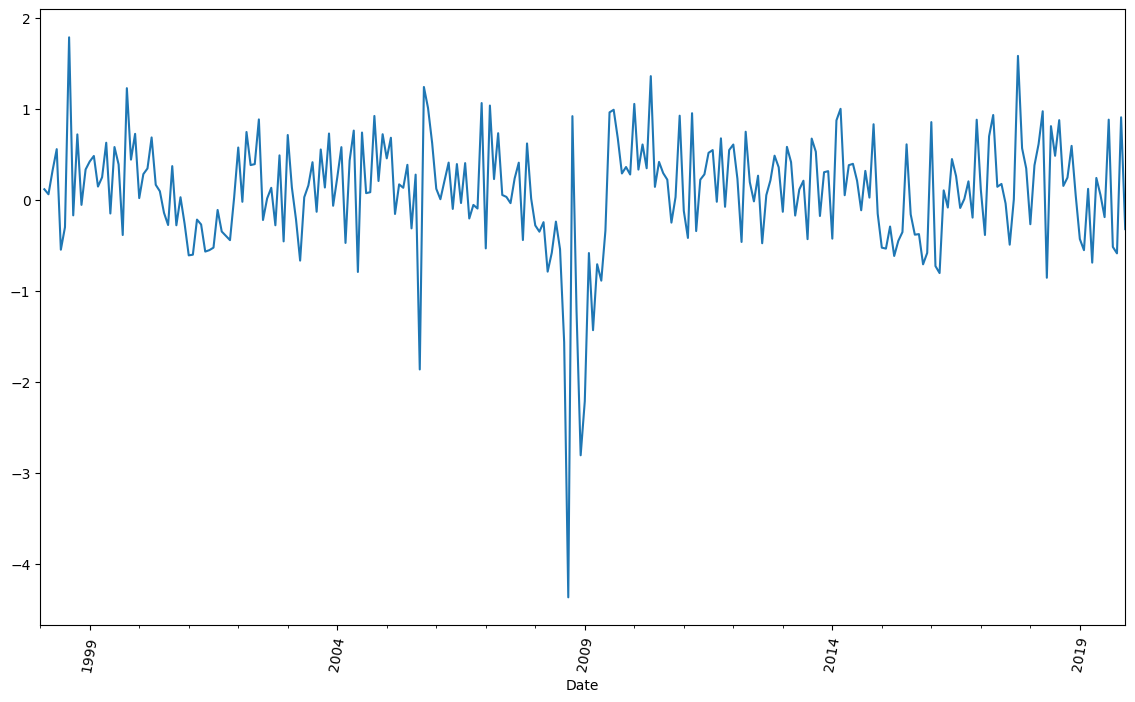

In [ ]:
df_new['Dif_1'] = df_new['IPI'] - df_new['IPI'].shift(1) # Criando uma coluna com a diferença entre o valor atual e o anterior
df_new['Dif_1'].plot(rot = 80, figsize = (14,8)); # Plotando a diferença

#### Verificando a estacionariedade novamente:

In [ ]:
adf_check(df_new['Dif_1'].dropna()) # Verificando se a série é estacionária e se há tendência. Usando a função adf_check criada anteriormente e dropando os valores nulos.

Augmented Dickey-Fuller Test
Critical values:
	1%: -3.4561550092339512
	5%: -2.8728972266578676
	10%: -2.5728222369384763
ADF Test Statistic : -4.089108633922363
p-value : 0.0010094605899151749
# of lags : 6
Num of Obs used : 256
Reject null hypothesis
Data has no unit root and is stationary


In [ ]:
#If need to take a second difference

#df_new['Dif_2'] = df_new['Dif_1'] - df_new['Dif_1'].shift(1)
#adf_check(df_new['Dif_2'].dropna())

### 2. Diferença sazonal

#### 2.1 Tirando a diferença sazonal

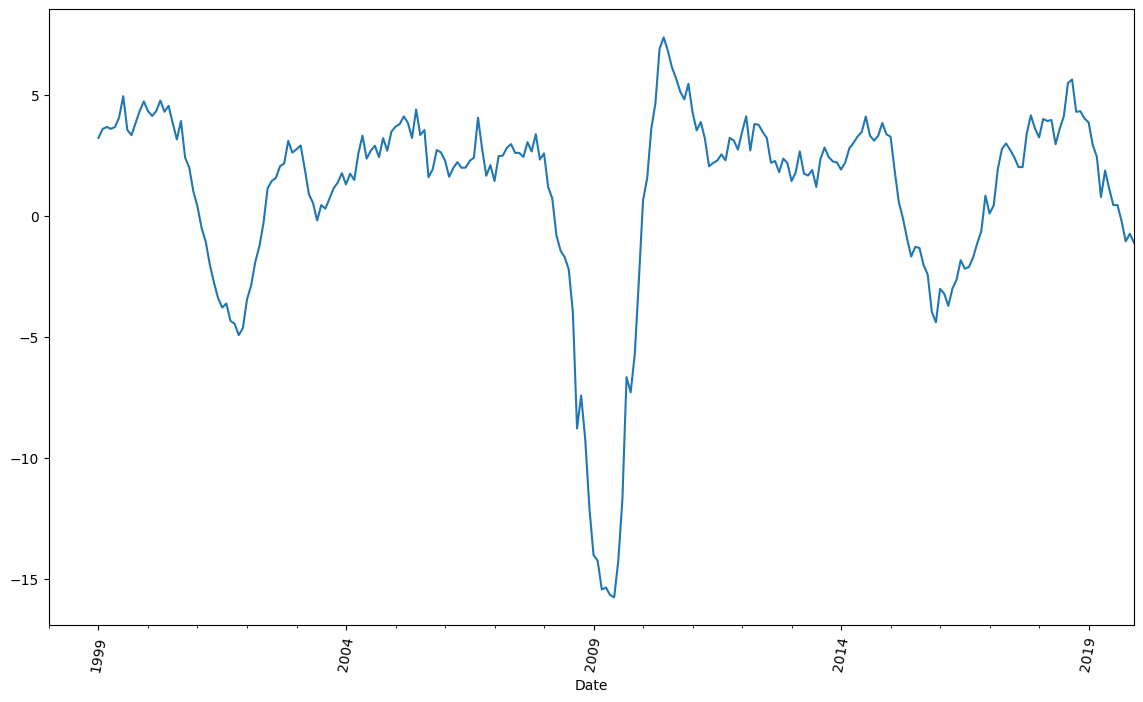

In [ ]:
df_new['Dif_Season'] = df_new['IPI'] - df_new['IPI'].shift(12) # Criando uma coluna com a diferença entre o valor atual e o valor do mesmo mês do ano anterior
df_new['Dif_Season'].plot(rot = 80, figsize = (14,8));

In [ ]:
adf_check(df_new['Dif_Season'].dropna()) # Verificando se a série é estacionária e se há tendência. Usando a função adf_check criada anteriormente e dropando os valores nulos.

Augmented Dickey-Fuller Test
Critical values:
	1%: -3.4584868856997004
	5%: -2.873918902362675
	10%: -2.573367247623359
ADF Test Statistic : -3.6878551168996947
p-value : 0.004287262331784953
# of lags : 16
Num of Obs used : 235
Reject null hypothesis
Data has no unit root and is stationary


Even though T-stats value is close to the Critical values, p-value is too high. Result: The data is non-stationary.
Mesmo que o valor de T-stats esteja próximo dos valores Críticos, o p-value é muito alto. Resultado: os dados não são estacionários.

#### 2.2 Efeito sazonal da primeira diferença:

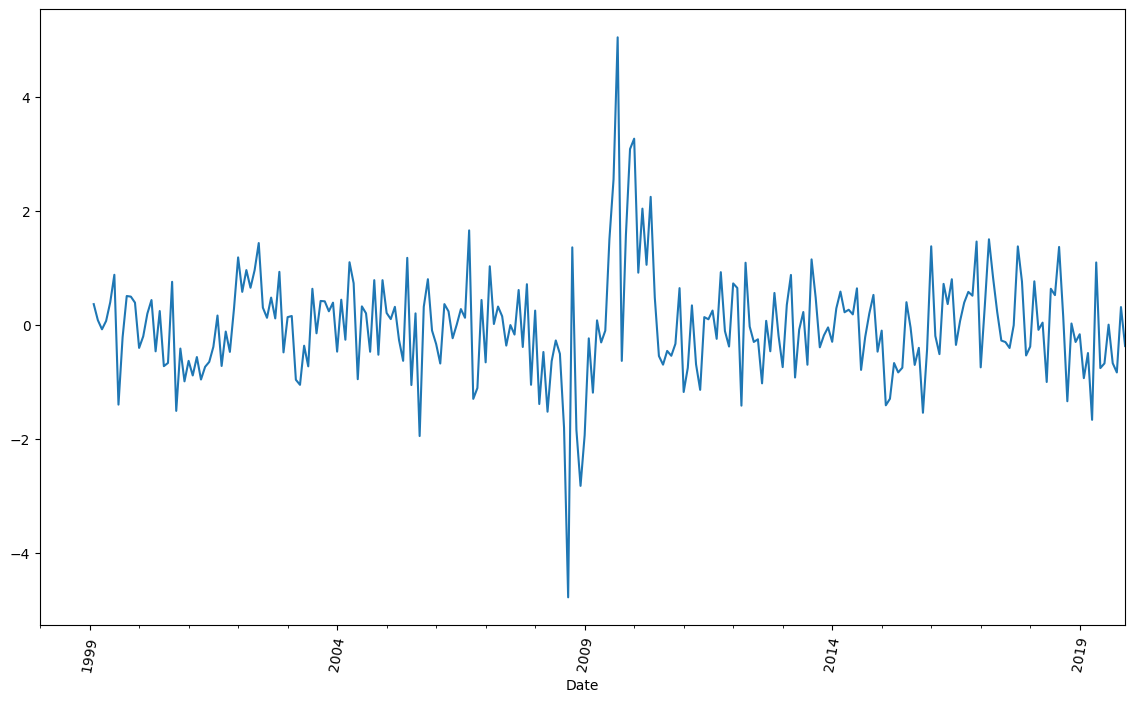

In [ ]:
df_new['Dif_Season_1'] = df_new['Dif_1'] - df_new['Dif_1'].shift(12) 
df_new['Dif_Season_1'].plot(rot = 80, figsize = (14,8));

In [ ]:
adf_check(df_new['Dif_Season_1'].dropna())

Augmented Dickey-Fuller Test
Critical values:
	1%: -3.4583663275730476
	5%: -2.8738660999177132
	10%: -2.5733390785693766
ADF Test Statistic : -4.54783176993663
p-value : 0.00016099997306299568
# of lags : 14
Num of Obs used : 236
Reject null hypothesis
Data has no unit root and is stationary


2.3 Diferença Média

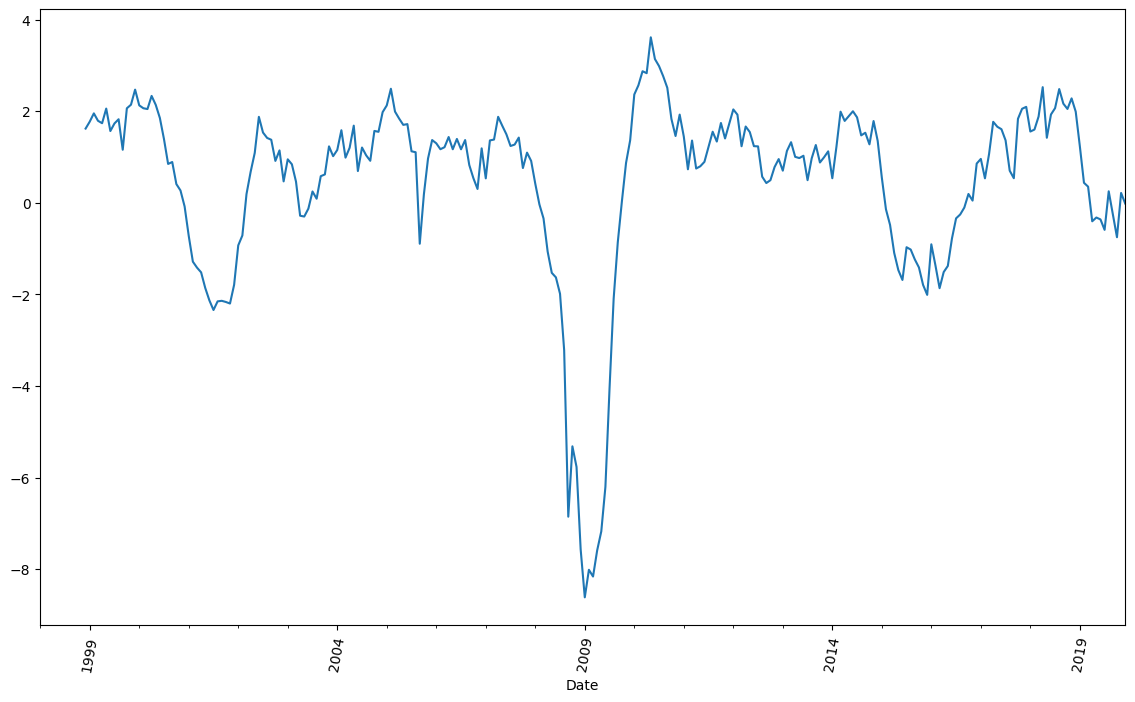

In [ ]:
df_new['Dif_mean'] = df_new['IPI'] - df_new['IPI'].rolling(12).mean()
df_new['Dif_mean'].plot(rot = 80, figsize = (14,8));

In [ ]:
adf_check(df_new['Dif_mean'].dropna())

Augmented Dickey-Fuller Test
Critical values:
	1%: -3.4573260719088132
	5%: -2.873410402808354
	10%: -2.573095980841316
ADF Test Statistic : -4.507353837719713
p-value : 0.00019071024772394687
# of lags : 7
Num of Obs used : 245
Reject null hypothesis
Data has no unit root and is stationary


## Conclusão:

De todos os resultados do teste ADF, o melhor resultado será a diferença sazonal da 1ª diferença. Então, no nosso caso, isso é df_new['Dif_Season_1'].

## Decomposição Sazonal de Componentes de Séries Temporais

#### Tendência: 
Movimento ascendente ou descendente dos dados ao longo do tempo.
#### Sazonalidade: 
Variação sazonal.
#### Ruído: 
Picos e gotas em intervalos aleatórios.

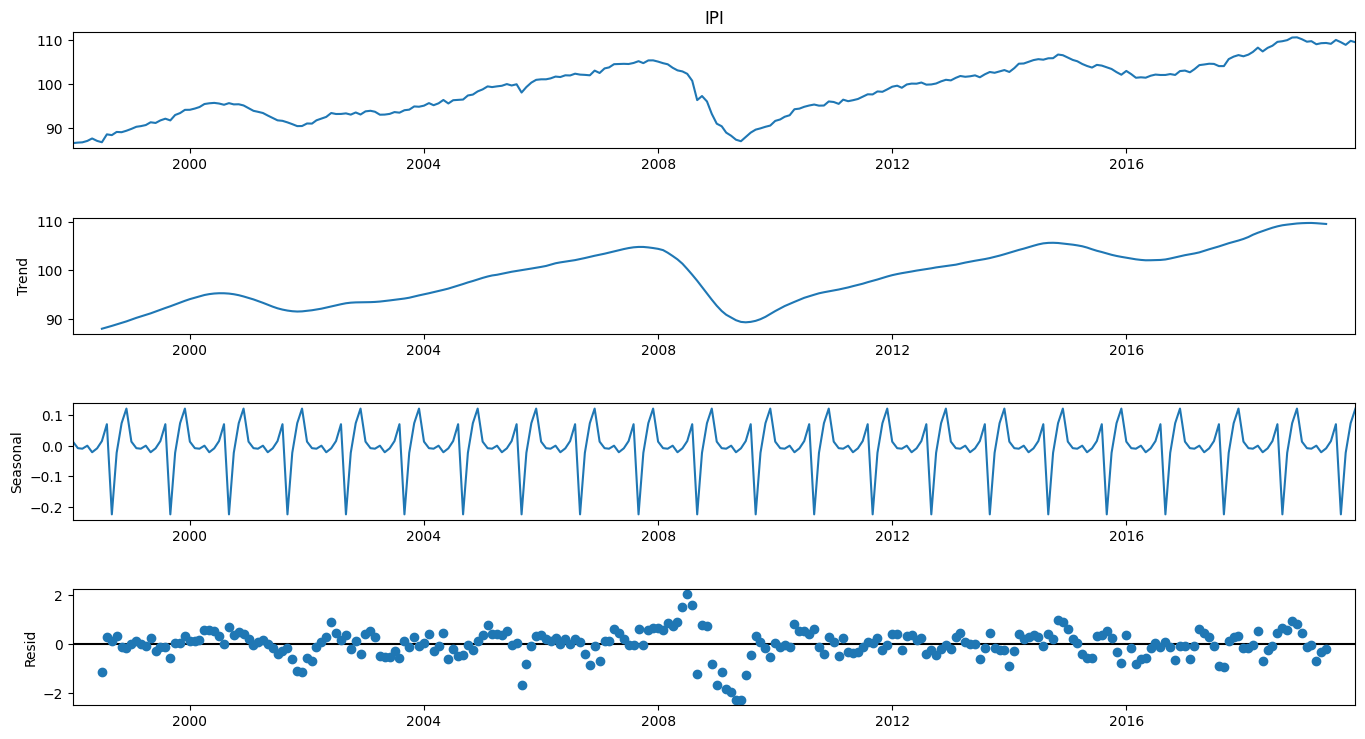

In [ ]:
# Plotando o gráfico de autocorrelação utilizando a função seasonal_decompose do statsmodels
decomp = seasonal_decompose(time_series)
fig = decomp.plot()
fig.set_size_inches(15,8)

## Função de Autocorrelação (ACF) e Função de Autocorrelação Parcial (PACF)

Como df_log['Dif_1'] no teste ADF deu os resultados mais preferíveis, eu plotaria os gráficos AC e PAC apenas para esses dados. A função de autocorrelação é usada para determinar o número de termos MA e a Autocorrelação parcial é para termos AR.

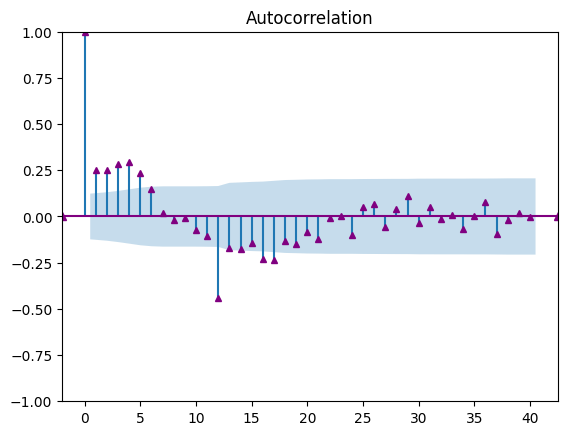

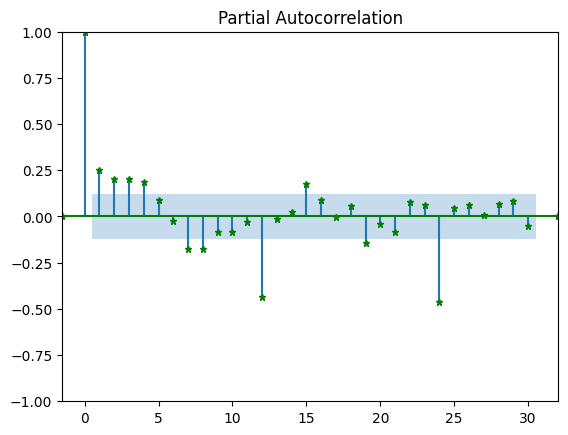

In [ ]:
acf_seasonal = plot_acf(df_new['Dif_Season_1'].dropna(), lags = 40, color = "purple", marker = "^") # Plotando o gráfico de autocorrelação
pacf_plot = plot_pacf(df_new['Dif_Season_1'].dropna(), lags = 30, color = "Green", marker = "*") # Plotando o gráfico de autocorrelação parcial

## ARIMA Model

Com base nos gráficos AC e PAC, podemos escolher as ordens AR e MA para o modelo ARIMA. Além disso, para AR é o número de observações de atraso do resultado ADF. E para MA é o tamanho da janela MA.

Observação:
* Se o gráfico de autocorrelação mostrar autocorrelação positiva na primeira defasagem (lag-1), sugere-se usar os termos AR em relação à defasagem.
* Se o gráfico de autocorrelação mostrar autocorrelação negativa na primeira defasagem, ele sugere o uso de termos MA.

In [27]:
#model = ARIMA(df_new['IPI'], order = (14,1,12))
model = sm.tsa.statespace.SARIMAX(df_new['IPI'],order=(14,1,12), seasonal_order=(1,1,1,12))
model_result = model.fit()
print(model_result.summary());

                                  Statespace Model Results                                  
Dep. Variable:                                  IPI   No. Observations:                  264
Model:             SARIMAX(14, 1, 12)x(1, 1, 1, 12)   Log Likelihood                -224.760
Date:                              Sun, 20 Nov 2022   AIC                            507.520
Time:                                      02:22:25   BIC                            609.758
Sample:                                  01-01-1998   HQIC                           548.663
                                       - 12-01-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1928      0.160     -1.203      0.229      -0.507       0.121
ar.L2          0.07

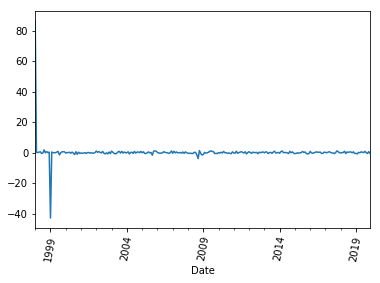

In [28]:
# Plotando o gráfico com residuos
model_result.resid.plot(rot = 80);

#KDE plot: 
* KDE plot é usado para estimar a densidade de probabilidade de uma variável aleatória contínua.
* model_result.resid.plot(kind = 'kde');

In [29]:
#criando datas futuras adicionais:
forecast_dates = [df_new.index[-1] + DateOffset(months=x) for x in range(1,24)]
df_future = pd.DataFrame(index=forecast_dates, columns = df_new.columns)
df_final = pd.concat([df_new, df_future])

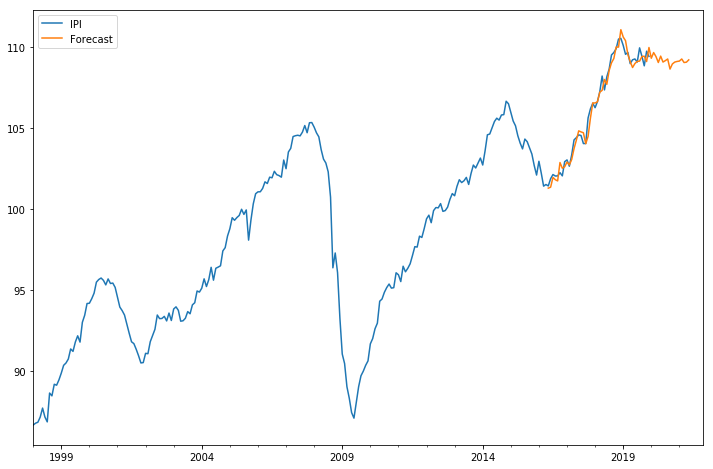

In [30]:
df_final['Forecast'] = model_result.predict(start=220,end=280, alpha = 0.05)
df_final[['IPI','Forecast']].plot(figsize = (12,8));

## Gráficos de diagnóstico

Queremos que os resíduos sejam processados para se tornar ruído branco

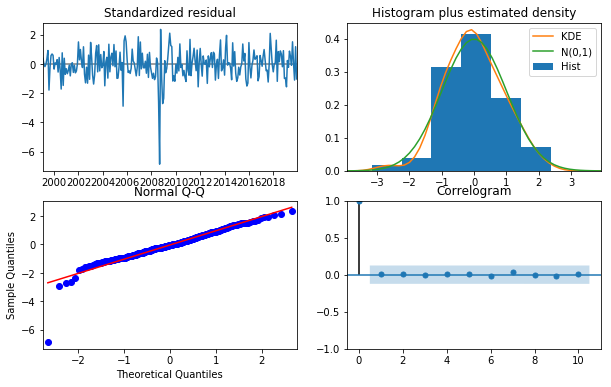

In [31]:
y = model_result.plot_diagnostics(figsize = (10,6))

### Para adicionar intervalos de confiança:

In [32]:
forecast = model_result.get_forecast(steps = 60)
conf_int = forecast.conf_int()

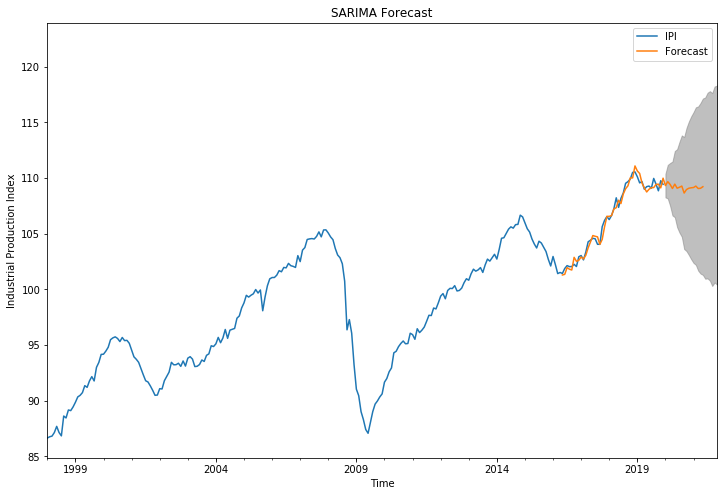

In [33]:
ax = df_final[['IPI','Forecast']].plot(figsize = (12,8))
ax.fill_between(conf_int.index,
               conf_int.iloc[:, 0],
               conf_int.iloc[:,1], color = 'grey', alpha = 0.5)
ax.set_xlabel('Time')
ax.set_ylabel('Industrial Production Index')
ax.set_title('SARIMA Forecast')
plt.legend();

Minha previsão para o Índice de Produção Industrial dos EUA. Estou muito feliz com meus resultados. No entanto, o intervalo de confiança é muito amplo.